In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

# Random Walk
State Aggregation on the $1000$-state Random Walk Consider a $1000$-state version of the random walk task (Examples 6.2 and 7.1 on pages 125 and 144). The states are numbered from $1$ to $1000$, left to right, and all episodes begin near the center, in state $500$. State transitions are from the current state to one of the $100$ neighboring states to its left, or to one of the 100 neighboring states to its right, all with equal probability. Of course, if the current state is near an edge, then there may be fewer than $100$ neighbors on that side of it. In this case, all the probability that would have gone into those missing neighbors goes into the probability of terminating on that side (thus, state 1 has a $0.5$ chance of terminating on the left, and state $950$ has a $0.25$ chance of terminating on the right). As usual, termination on the left produces a reward of $-1$, and termination on the right produces a reward of $+1$. All other transitions have a reward of zero. 

# True Value function using DP

## Transition Matrix P

In [2]:
P = np.zeros((1002,1002))
P[0,0] = 1
P[-1,-1] = 1
for i in range(1,1001):
    Min = max(i-100,1)
    Max = min(i+100,1000)
    for j in range(Min,i):
        P[i,j] = 1/200
    P[i,0] = 1/2 - (i-Min)/200
    for j in range(i+1,Max+1):
        P[i,j] = 1/200
    P[i,1001] = 1/2 - (Max-i)/200

## Expected reward in one step

In [3]:
R = np.zeros((1002,1))
R[0] = -1
R[1001] = 1
mu_r = P @ R

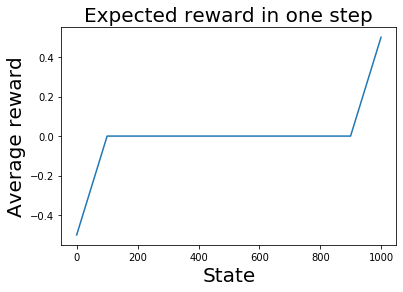

In [4]:
plt.plot(np.arange(1000), mu_r[1:1001])


plt.xlabel('State', fontsize=20)
plt.ylabel('Average reward', fontsize=20)
plt.title('Expected reward in one step', fontsize=20)
plt.show()

## Iterative Policy Evaluation

We use DP to compute the value function. 

In [5]:
V_True = np.zeros(1002)
delta = 1
while delta > 1e-8:
    delta = 0
    for s in range(1,1001):
        temp = V_True[s]
        V_True[s] = mu_r[s] + P[s].dot(V_True) 
        delta = max(delta, np.abs(V_True[s]-temp))

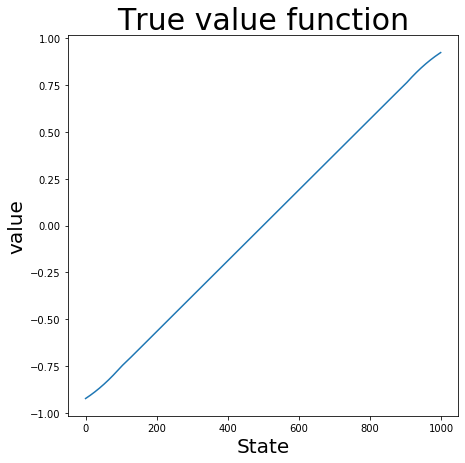

In [6]:
plt.subplots(figsize=(7, 7))

plt.plot(V_True[1:1001])

plt.xlabel('State', fontsize=20)
plt.ylabel('value', fontsize=20)
plt.title('True value function', fontsize=30)
plt.show()

## The on-policy distribution



See "The on-policy distribution in episodic tasks" box in page 199.
We need it to compute "The Root Mean Squared Value Error". 

In [7]:
D = np.zeros(1002)
D[500] = 1
eta = np.zeros(1002)
delta = 1
while delta > 1e-8:
    delta = 0
    for s in range(1,1001):
        temp = eta[s]
        eta[s] = D[s] + P.T[s].dot(eta) 
        delta = max(delta, np.abs(eta[s]-temp))
eta= eta[1:1001]/eta[1:1001].sum()

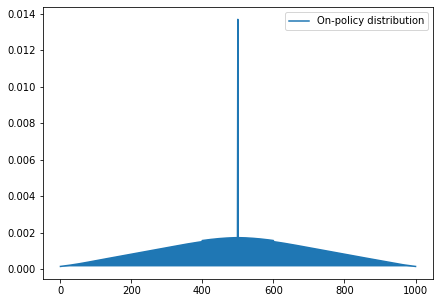

In [8]:
plt.subplots(figsize=(7, 5))
x, y = list(range(1,1001)), eta
plt.plot(x,y, label = 'On-policy distribution')
plt.fill(x,y)
plt.legend()
plt.show()

# Example 9.1: State Aggregation on the 1000-state Random Walk

In [9]:
class Env:
    def __init__(self,road_len = 1000, start = 500, action_range=100):
        self.states = list(range(1,1001))
        self.start = start
        self.reset()
        
    def reset(self):
        self.state = self.start
        self.end = False
        
    def step(self):
        action = np.random.choice(list(range(-100,0)) + list(range(1,101)))
        state = self.state
        self.state += action
        if self.state >= 1001:
            self.end = True
            reward = +1
        elif self.state <= 0:
            self.end = True
            reward = -1
        else:
            reward = 0
        return state, action, reward
    
    def buid_trj(self):
        trj = []
        while not self.end:
            trj.append(self.step())
        return trj

## Computing the value function using tabular MC technique

In [10]:
class tabular_MC:
    def __init__(self, env, n_iter = 10000, step_size = 1e-1):
        self.Q = np.zeros(1000)
        for i in range(n_iter):
            
            if (1+i)%100 ==0:
                step_size *= .9
                
            G = 0
            trj = env.buid_trj()
            while len(trj) > 0:
                state, action, reward =  trj.pop()
                G += reward
                self.Q[state-1] += step_size * (G - self.Q[state-1])
            env.reset()

In [11]:
t = time.time()
env = Env()
model_MC = tabular_MC(env = env, n_iter = 10000, step_size = 5e-1)
print(time.time()-t)

25.722475051879883


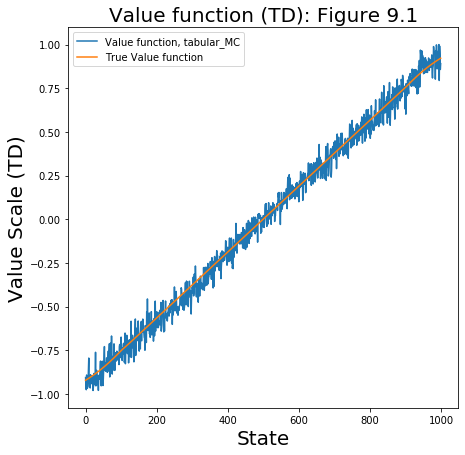

In [12]:
plt.subplots(figsize=(7, 7))

plt.plot(model_MC.Q, label = 'Value function, tabular_MC')
plt.plot(V_True[1:1001], label = 'True Value function')

plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale (TD)', fontsize=20)
plt.title('Value function (TD): Figure 9.1', fontsize=20)
plt.legend()
plt.show()

## Lets compute the value function using tabular TD technique

In [13]:
class tabular_TD:
    def __init__(self, env, n_iter = 10000, step_size = 1e-1):
        self.Q = np.zeros(1000)
        for i in range(n_iter):
            
            if (1+i)%100 ==0:
                step_size *= .95
                
            while not env.end:
                state, action, reward = env.step()
                if env.end:
                    temp = 0
                else:
                    temp = self.Q[env.state-1]
                self.Q[state-1] += step_size * (reward + temp - self.Q[state-1])
            env.reset()

In [14]:
t = time.time()
env = Env()
model_TD = tabular_TD(env = env, n_iter = 10000, step_size = 5e-1)
print(time.time()-t)

24.892606019973755


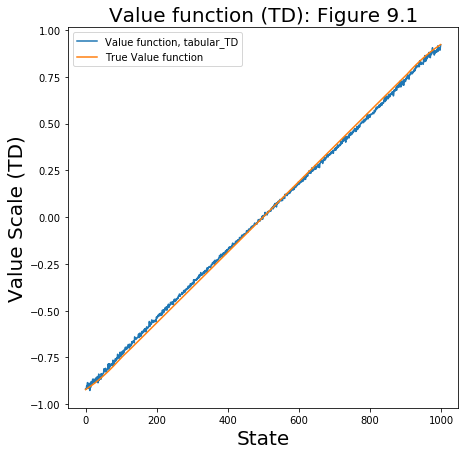

In [15]:
plt.subplots(figsize=(7, 7))

plt.plot(model_TD.Q, label = 'Value function, tabular_TD')
plt.plot(V_True[1:1001], label = 'True Value function')

plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale (TD)', fontsize=20)
plt.title('Value function (TD): Figure 9.1', fontsize=20)
plt.legend()
plt.show()

# Value function  approximation 

Our objective is to Find the approximate value function learned by the gradient Monte-Carlo/Temporal-Difference algorithm with state aggregation after $100000$ episodes with a step size of $\alpha = 2 \times 10^{-5}$. For the state aggregation, the $1000$ states were partitioned into $10$ groups of $100$ states each (i.e., states $1-100$ were one group, states $101-200$ were another, and so on).


## 1) Computing the value function using gradient MC technique (State Aggregation)

In [16]:
class gradient_MC:
    def __init__(self, env, n_iter = 10000, step_size = 1e-1):
        self.W = np.zeros(100)
        self.Q = np.zeros(1000)
        for i in range(n_iter):
            
            if (1+i)%100 ==0:
                step_size *= .9
                
            G = 0
            trj = env.buid_trj()
            while len(trj) > 0:
                state, action, reward =  trj.pop()
                G += reward
                self.W[(state-1)//100] += step_size * (G - self.W[(state-1)//100])
            env.reset()
        for i in range(1000):
            self.Q[i] = self.W[i//100]

In [17]:
t = time.time()
env = Env()
model_gradient_MC = gradient_MC(env = env, n_iter = 5000, step_size = 2e-3)
print(time.time()-t)

15.307732820510864


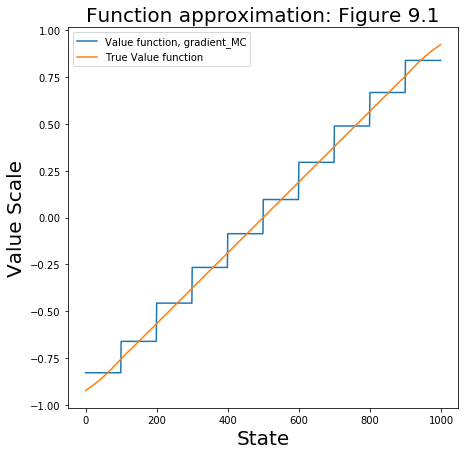

In [18]:
plt.subplots(figsize=(7, 7))

plt.plot(model_gradient_MC.Q, label = 'Value function, gradient_MC')
plt.plot(V_True[1:1001], label = 'True Value function')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Function approximation: Figure 9.1', fontsize=20)
plt.legend()
plt.show()

## 2) Computing the value function using gradient TD technique (State Aggregation)

In [19]:
class gradient_TD:
    def __init__(self, env, n_iter = 10000, step_size = 1e-1):
        self.W = np.zeros(100)
        self.Q = np.zeros(1000)
        for i in range(n_iter):
            
            if (1+i)%100 ==0:
                step_size *= .95
                
            while not env.end:
                state, action, reward = env.step()
                if env.end:
                    temp = 0
                else:
                    temp = self.W[(env.state-1)//100]
                self.W[(state-1)//100] += step_size * (reward + temp - self.W[(state-1)//100])
            env.reset()
        
        for i in range(1000):
            self.Q[i] = self.W[i//100]

In [20]:
t=time.time()
env = Env()
model_gradient_TD = gradient_TD(env = env, n_iter = 10000, step_size = 1e-2)
print(time.time()-t)

29.865277767181396


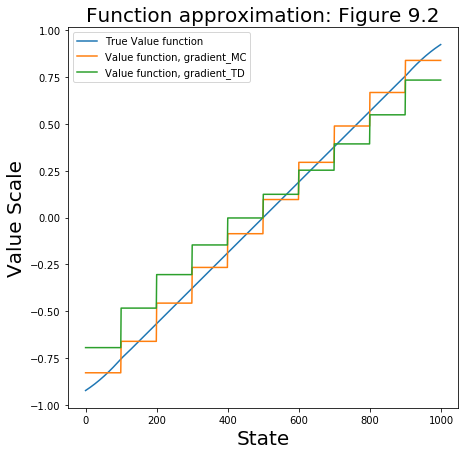

In [21]:
plt.subplots(figsize=(7, 7))


plt.plot(V_True[1:1001], label = 'True Value function')
plt.plot(model_gradient_MC.Q, label = 'Value function, gradient_MC')
plt.plot(model_gradient_TD.Q, label = 'Value function, gradient_TD')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Function approximation: Figure 9.2', fontsize=20)
plt.legend()
plt.show()

# Feature Construction for Linear Methods

## 1) Gradient Monte Carlo method with Fourier and polynomial basis

In [22]:
class linear_MC:
    def __init__(self, env, feature_map, n_features, n_iter = 10000, step_size = 1e-1):
        
        self.W = 1e-2* np.random.normal(0,1, n_features)
        self.X = np.zeros((1000, n_features)).astype(float)
        self.error = []
        for s in range(1, 1001):
            self.X[s-1] = feature_map(n_features, s)
        self.V = np.zeros(1000)
        for i in range(n_iter):
            
            if (1+i)%100 == 0: #300
                step_size *= .95
                
            G = 0
            trj = env.buid_trj()
            while len(trj) > 0:
                state, action, reward =  trj.pop()
                G += reward
                self.W += step_size * (G - self.W.dot(self.X[state-1])) * self.X[state-1]
            temp = self.X @ self.W.reshape(-1,1)
            A = (temp-V_True[1:1001].reshape(-1,1))
            self.error.append(np.sqrt(np.sum(A**2)* eta[s-1]))
            env.reset()

## Feature Constructions

### 1) Polynomial feature Assignment 

In [23]:
def Poly(n,s):
    return np.array([1]+[(s/1000)**k for k in range(1,n)])

#### 1) Lets try the simplest feature assignment: to each state $s\in\{1,\ldots,1000\}$, we assign two features $(1,s/1000)$.  As the true value fuction is nearly linear, linear method with this feature assignment works extreamly good as expected. 

In [24]:
t=time.time()
error_lmc = np.zeros(5000)
V_lmc = np.zeros(1000)
k=3
for i in range(k):
    env = Env()
    model_gradient_LMC = linear_MC(env = env, feature_map = Poly, n_features = 2, 
                              n_iter = 5000, step_size = 1e-3)
    error_lmc = error_lmc + np.array(model_gradient_LMC.error)
    V_lmc = V_lmc + np.array(model_gradient_LMC.X @ model_gradient_LMC.W)
print(time.time()-t)

44.96132516860962


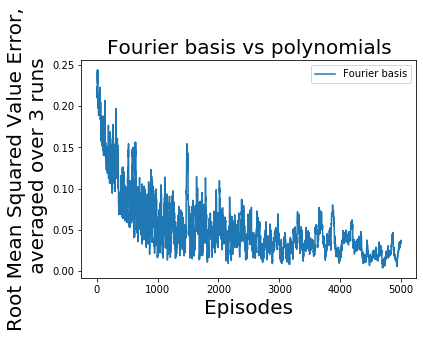

In [25]:
plt.plot(error_lmc/k, label = 'Fourier basis')


plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Root Mean Squared Value Error,\n averaged over %s runs' %k, fontsize=20)
plt.title('Fourier basis vs polynomials', fontsize=20)
plt.legend()
plt.show()

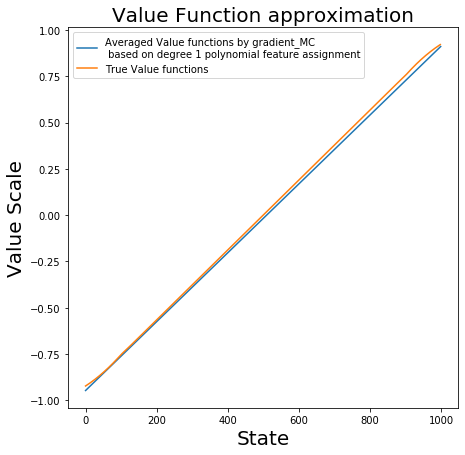

In [26]:
plt.subplots(figsize=(7, 7))


plt.plot(V_lmc/k, 
         label = 'Averaged Value functions by gradient_MC\n based on degree 1 polynomial feature assignment')
plt.plot(V_True[1:1000], 
         label = 'True Value functions')

plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

## Polynomial basis

Now, lets try some high degree polynomial feature assignments!

In [27]:
t = time.time()
error_p = np.zeros(5000)
V_pmc = np.zeros(1000)
k=3
for i in range(k):
    env = Env()
    model_gradient_PMC = linear_MC(env = env, feature_map = Poly, n_features = 10, 
                              n_iter = 5000, step_size = 1e-3)
    error_p = error_p + np.array(model_gradient_PMC.error)
    V_pmc = V_pmc + np.array(model_gradient_PMC.X @ model_gradient_PMC.W)
print(time.time()-t)

47.949461936950684


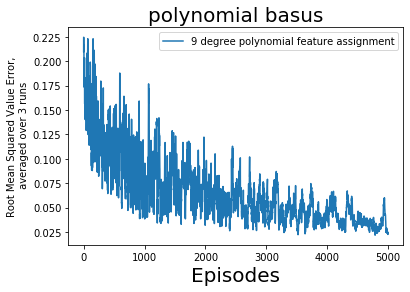

In [28]:
plt.plot(error_p/k, label = '9 degree polynomial feature assignment')


plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Root Mean Squared Value Error,\n averaged over %s runs'%k, fontsize=10)
plt.title('polynomial basus', fontsize=20)
plt.legend()
plt.show()

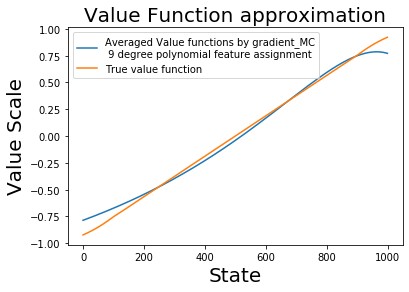

In [29]:
plt.plot(V_pmc/k, 
         label = 'Averaged Value functions by gradient_MC\n 9 degree polynomial feature assignment')
plt.plot(V_True[1:1001], label = 'True value function')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

## Fourier basis

In [30]:
def Fourier(n,s):
    return np.array([np.cos(i*np.pi*s/1000) for i in range(0,n)])

In [31]:
t = time.time()
error_f = np.zeros(5000)
V_fmc = np.zeros(1000)
k=3
for i in range(k):
    env = Env()
    model_gradient_FMC = linear_MC(env = env, feature_map = Fourier, n_features = 10, 
                              n_iter = 5000, step_size = 5e-4)
    error_f = error_f + np.array(model_gradient_FMC.error)
    V_fmc = V_fmc + np.array(model_gradient_FMC.X @ model_gradient_FMC.W)
print(time.time()-t)

53.7079381942749


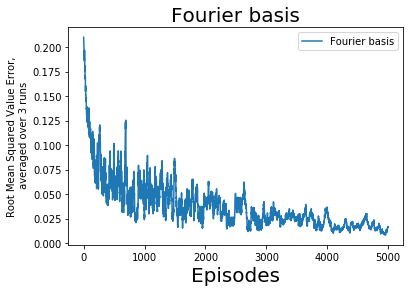

In [32]:
plt.plot(error_f/k, label = 'Fourier basis')


plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Root Mean Squared Value Error,\n averaged over %s runs'%k, fontsize=10)
plt.title('Fourier basis', fontsize=20)
plt.legend()
plt.show()

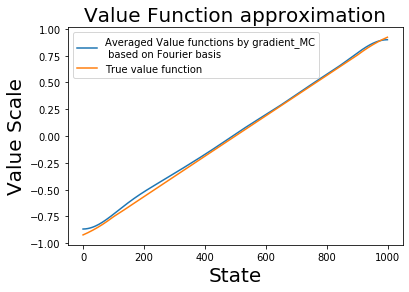

In [33]:
plt.plot(V_fmc/k, 
         label = 'Averaged Value functions by gradient_MC\n based on Fourier basis')
plt.plot(V_True[1:1001], label = 'True value function')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

## Fourier basis vs polynomials on the $1000$-state random walk

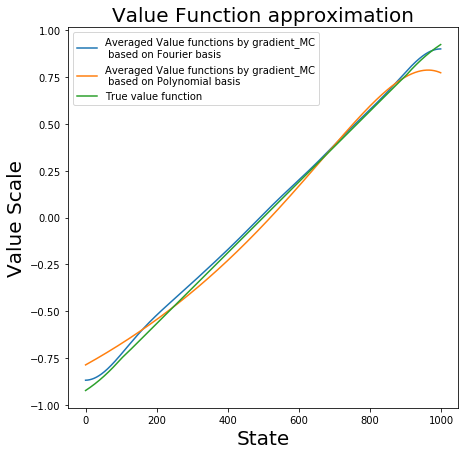

In [34]:
plt.subplots(figsize=(7, 7))

plt.plot(V_fmc/k, 
         label = 'Averaged Value functions by gradient_MC\n based on Fourier basis')
plt.plot(V_pmc/k, 
         label = 'Averaged Value functions by gradient_MC\n based on Polynomial basis')
plt.plot(V_True[1:1001], label = 'True value function')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

## 2) Gradient Temporal Difference method with Fourier and polynomial bases

In [35]:
class linear_TD:
    def __init__(self, env, feature_map, n_features, n_iter = 10000, step_size = 1e-1):
        
        self.W = 1e-2* np.random.normal(0,1, n_features)
        self.X = np.zeros((1000, n_features))
        self.error = []
        for s in range(1, 1001):
            self.X[s-1] = feature_map(n_features, s)
        self.V = np.zeros(1000)
        for i in range(n_iter):
            
            if (1+i)%100 == 0:
                step_size *= .95
            
            while not env.end:
                state, action, reward = env.step()
                if env.end:
                    temp = 0
                else:
                    temp = self.W.dot(self.X[env.state-1])
                self.W += step_size * (reward + temp - self.W.dot(self.X[state-1])) * self.X[state-1]
            temp = self.X @ self.W.reshape(-1,1)
            A = (temp-V_True[1:1001].reshape(-1,1))
            self.error.append(np.sqrt(np.sum(A**2)* eta[s-1]))
            env.reset()

In [36]:
t = time.time()
k = 1
n_iter = 5000
error_ftd = np.zeros(n_iter)
V_ftd = np.zeros(1000)
for _ in range(k):
    env = Env()
    model_gradient_FTD = linear_TD(env = env, feature_map = Fourier, 
                                    n_features = 5, n_iter = n_iter, step_size = 5e-3)
    error_ftd = error_ftd + np.array(model_gradient_FTD.error)
    V_ftd = V_ftd + np.array(model_gradient_FTD.X @ model_gradient_FTD.W)
print(time.time()-t)

20.970837831497192


In [37]:
t=time.time()
error_ptd = np.zeros(n_iter)
V_ptd = np.zeros(1000)
for _ in range(k):
    env = Env()
    model_gradient_PTD = linear_TD(env = env, feature_map = Poly, 
                                    n_features = 5, n_iter = n_iter, step_size = 5e-2)
    error_ptd = error_ptd + np.array(model_gradient_PTD.error)
    V_ptd = V_ptd + np.array(model_gradient_PTD.X @ model_gradient_PTD.W)
print(time.time() - t)    

20.54021906852722


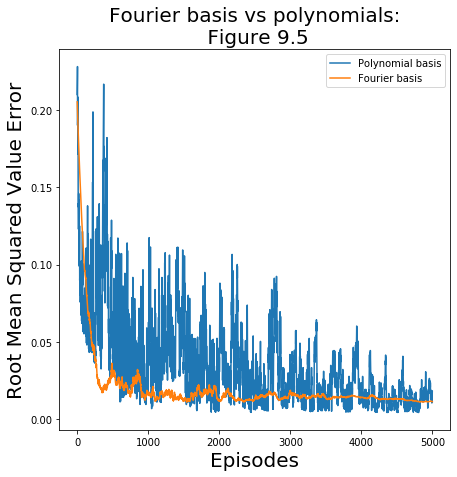

In [38]:
plt.subplots(figsize=(7, 7))


plt.plot(error_ptd/k, label = 'Polynomial basis')
plt.plot(error_ftd/k, label = 'Fourier basis')


plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Root Mean Squared Value Error', fontsize=20)
plt.title('Fourier basis vs polynomials:\n Figure 9.5', fontsize=20)
plt.legend()
plt.show()

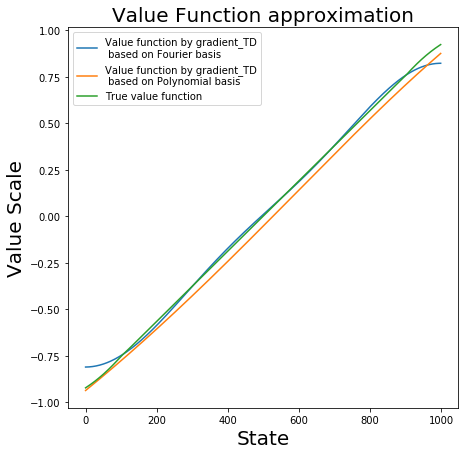

In [39]:
plt.subplots(figsize=(7, 7))


plt.plot(V_ftd/k, 
         label = 'Value function by gradient_TD\n based on Fourier basis')
plt.plot(V_ptd/k, 
         label = 'Value function by gradient_TD\n based on Polynomial basis')
plt.plot(V_True[1:1001], label = 'True value function')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

# Tile Coding


In [40]:
def TileCoding(state, n_tilings, n_states=1000, wideness=200, offset = 4):
    code = []
    n_tiles = 1+ n_states//wideness
    
    for x in range(n_tilings):
        code.append(x*n_tiles + (state + x*offset)//wideness)
    return np.array(code)

In [41]:
class linear_TileCoding_MC:
    def __init__(self, env, n_tilings, 
                 feature_map=TileCoding, wideness=200, 
                 n_iter = 100, step_size = 1e-1, reg = 1e-3):
        
        self.W = np.zeros(n_tilings * 6) 
        self.X = np.zeros((1000, n_tilings)).astype(int)
        self.V = np.zeros(1000)
        
        self.error = []
        for s in range(0, 1000):
            self.X[s] = feature_map(s, n_tilings)
        
        for i in range(n_iter):
            
            if (1+i)%100 == 0:
                step_size *= .95
                
            G = 0
            trj = env.buid_trj()
            while len(trj) > 0:
                state, action, reward =  trj.pop()
                G += reward
                v = self.W[self.X[state-1]].sum()
                self.W[self.X[state-1]] += step_size * (G - v)
                
            Er = ((eta * (self.W[self.X].sum(axis =1) - V_True[1:1001])**2)).sum()    
            self.error.append(np.sqrt(Er))
            env.reset()
            
        for s in range(1000):
            self.V[s] = self.W[self.X[s]].sum()

In [42]:
t1 = time.time()
k = 2
n_tilings = 50
step_size = (1e-3)/n_tilings
error50 = np.zeros(5000)
V50 = np.zeros(1000)
for _ in range(k):
    env = Env()
    model_TileCoding = linear_TileCoding_MC(env = env, n_tilings =n_tilings, 
                                            n_iter = 5000, step_size = step_size)
    error50 += model_TileCoding.error
    V50 += model_TileCoding.V
    
print(time.time()-t1)

38.48316693305969


In [43]:
t1 = time.time()
k = 2
n_tilings = 1
step_size = (1e-3)/n_tilings
error1 = np.zeros(5000)
V1 = np.zeros(1000)
for _ in range(k):
    env = Env()
    model_TileCoding = linear_TileCoding_MC(env = env, n_tilings =n_tilings, 
                                            n_iter = 5000, step_size = step_size)
    error1 += model_TileCoding.error
    V1 += model_TileCoding.V
    
print(time.time()-t1)

35.034852027893066


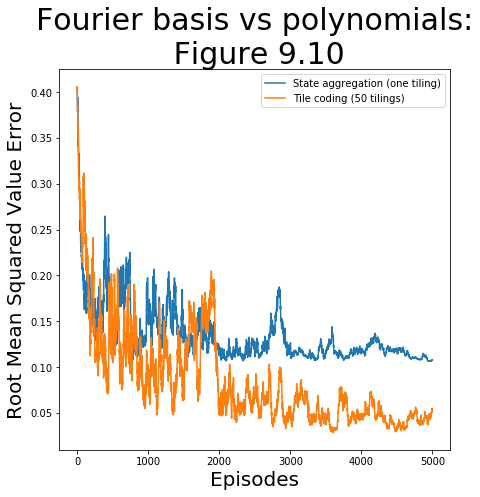

In [44]:
plt.subplots(figsize=(7, 7))


plt.plot(error1/k, label = 'State aggregation (one tiling)')
plt.plot(error50/k, label = 'Tile coding (50 tilings)')


plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Root Mean Squared Value Error', fontsize=20)
plt.title('Fourier basis vs polynomials:\n Figure 9.10', fontsize=30)
plt.legend()
plt.show()

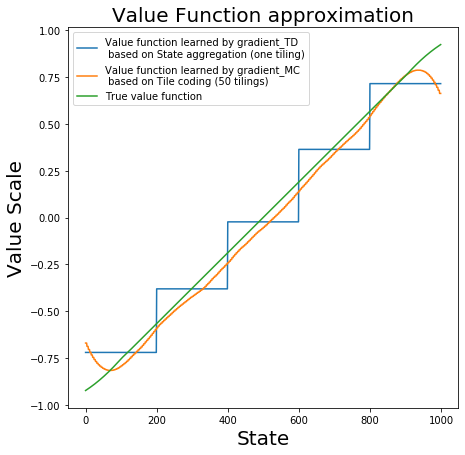

In [45]:
plt.subplots(figsize=(7, 7))


plt.plot(V1/k, 
         label = 'Value function learned by gradient_TD\n based on State aggregation (one tiling)')
plt.plot(V50/k, 
         label = 'Value function learned by gradient_MC\n based on Tile coding (50 tilings)')
plt.plot(V_True[1:1001], label = 'True value function')


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

# Lets try Kernel technique 

The $d$-degree polynomial kernel is defined as
$$K(x,y) = (x^ty+c)^d.$$
In the follwoing, we work with $3$-degree polynomial kernel applying on feature assignment based on Fourier basis.

In [46]:
def PK(w, x, gamma=0):
    return (.9+x@w)**3
def grad_PK(w,x, gamma=0):
    return (3*(.9+x@w)**2)*x

### 1) Using MC Methood 

In [47]:
class Kernel_MC:
    def __init__(self, env, feature_map, n_features, 
                 kernel = PK, grad = grad_PK, 
                 n_iter = 10000, step_size = 1e-1, gamma = 0):
        
        
        self.X = np.zeros((1000, n_features))
        for s in range(1, 1001):
            self.X[s-1] = feature_map(n_features, s)
        
        self.W = 1e-2* np.random.normal(0, 1, self.X.shape[1])

        self.V = np.zeros(1000)
        self.error = []
        
        for i in range(n_iter):
            if (i+1)%100 ==0:
                step_size*= .95
                
            G = 0
            trj = env.buid_trj()
            SS = trj[1][2]
            while len(trj) > 0:
                
                state, action, reward =  trj.pop()
                G += reward
                self.W += (step_size * 
                           (G - kernel(self.W, self.X[state-1], gamma)) * 
                           grad(self.W, self.X[state-1], gamma))
                
            self.V = np.array([kernel(self.W, self.X[x], gamma) for x in range(1000)])
            A = (self.V - V_True[1:-1])**2
            self.error.append(np.sqrt(np.sum(A*eta)))
            env.reset()

In [48]:
t = time.time()
m=5000
k=3
error_PK = np.zeros(m)
V_model1 = np.zeros(1000)
for i in range(k):
    env = Env()
    model1 = Kernel_MC(env = env, feature_map = Fourier, n_features = 10, 
                      kernel = PK, grad = grad_PK, 
                      n_iter = m, step_size = 1e-3)
    error_PK = error_PK + np.array(model1.error)
    V_model1 = V_model1 + model1.V
print(time.time()-t)

102.61590194702148


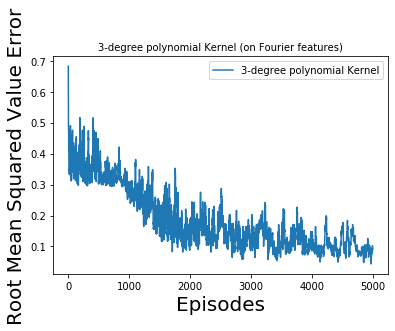

In [49]:
plt.plot(error_PK/k, label= "3-degree polynomial Kernel")
plt.xlabel('Episodes', fontsize=20)
plt.ylabel('Root Mean Squared Value Error', fontsize=20)
plt.title('3-degree polynomial Kernel (on Fourier features)', fontsize=10)
plt.legend()
plt.show()

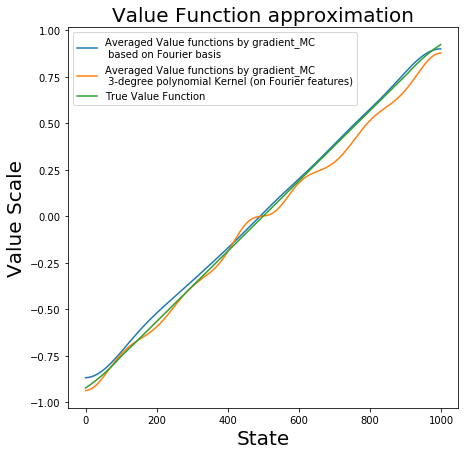

In [50]:
plt.subplots(figsize=(7, 7))

plt.plot(V_fmc/k, 
         label = 'Averaged Value functions by gradient_MC\n based on Fourier basis')

plt.plot(V_model1/k, 
         label = 'Averaged Value functions by gradient_MC\n 3-degree polynomial Kernel (on Fourier features)')
plt.plot(V_True[1:-1], label="True Value Function")


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()

### 2) Using TD Method

In [51]:
class Kernel_TD:
    def __init__(self, env, feature_map, n_features, 
                 kernel = PK, grad = grad_PK, 
                 n_iter = 10000, step_size = 1e-1, gamma = 0):
        
        
        self.X = np.zeros((1000, n_features))
        for s in range(1, 1001):
            self.X[s-1] = feature_map(n_features, s)
        
        self.W = 1e-2* np.random.normal(0, 1, self.X.shape[1])
        #self.W = Z np.zeros(self.X.shape[1])

        self.V = np.zeros(1000)
        self.error = []
        
        
        for i in range(n_iter):
            
            if (i+1)% 500 ==0:
                step_size*= .95
                
            while not env.end:
                state, action, reward = env.step()
                if env.end:
                    temp = 0
                else:
                    temp = kernel(self.W, self.X[env.state-1], gamma)
                self.W += (step_size * 
                           (reward + temp - kernel(self.W, self.X[state-1], gamma)) * 
                           grad(self.W, self.X[state-1], gamma))
                
            self.V = np.array([kernel(self.W, self.X[x], gamma) for x in range(1000)])
            A = (self.V - V_True[1:-1])**2
            self.error.append(np.sqrt(np.sum(A*eta)))
            env.reset()

In [52]:
t = time.time()
m=5000
k=1
error2 = np.zeros(m)
V_model2 = np.zeros(1000)
for i in range(k):
    env = Env()
    model2 = Kernel_TD(env = env, feature_map = Fourier, n_features = 10, 
                      kernel = PK, grad = grad_PK, 
                      n_iter = m, step_size = 1e-2)
    error2 = error2 + np.array(model2.error)
    V_model2 = V_model2 + model2.V
print(time.time()-t)

36.308382987976074


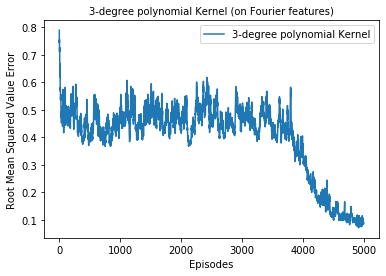

In [53]:
plt.plot(error2/k, label= "3-degree polynomial Kernel")
plt.xlabel('Episodes', fontsize=10)
plt.ylabel('Root Mean Squared Value Error', fontsize=10)
plt.title('3-degree polynomial Kernel (on Fourier features)', fontsize=10)
plt.legend()
plt.show()

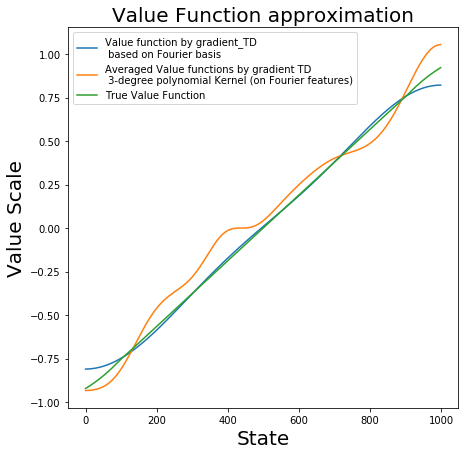

In [54]:
plt.subplots(figsize=(7, 7))

plt.plot(V_ftd/k, 
         label = 'Value function by gradient_TD\n based on Fourier basis')

plt.plot(V_model2/k, 
         label = 'Averaged Value functions by gradient TD\n 3-degree polynomial Kernel (on Fourier features)')
plt.plot(V_True[1:-1], label="True Value Function")


plt.xlabel('State', fontsize=20)
plt.ylabel('Value Scale', fontsize=20)
plt.title('Value Function approximation', fontsize=20)
plt.legend()
plt.show()